### Creating the blended sample
By Shooby, Sep 16th <br>
last edited: Sep 17th

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image


def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

%matplotlib inline

In [279]:
def brightest_center(im, r = 10):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans
    

In [434]:
def make_2blend(gals=3, lim_hmag =24, plot_it=True):
    '''This is to put together two candels GOODS_S galaxies into a single 64x64 cutout.
    I make sure in each cutout the central galaxy is brightest object in the cutout so 
    in rescaling and adding two components still show up. Also, one galaxy is put at 
    the center and the second in some random distance from it. both cutouts are rotated with
    a random angle. Cutouts are from HST H band for now.'''
    
    gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
    sel1 = (gs['zbest']>0.1)&(gs['zbest']<5.0)&(gs['CLASS_STAR']<0.95)&(gs['Hmag']<lim_hmag)&(gs['FWHM_IMAGE']>2)
    ra, dec,red = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1]
    
    im = np.zeros([64,64])
   
    data1 = np.zeros([100,100])
    while not(brightest_center(data1)):
        n = np.int(np.random.uniform(0,len(ra)-1))
        data1 = cut(ra[n],dec[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
        z1 = red[n]
    p,t = np.int(np.random.uniform(5,10)),np.int(np.random.uniform(5,10))
    s = data1[10+t:-10+t,10+p:-10+p]
    angle = np.random.uniform(0,180)
    so = ndimage.rotate(s,angle,mode='nearest',reshape=False)
    da1 = so[8:-8,8:-8]
    da = da1
    
    for i in range(gals):
        data2 = np.zeros([80,80])
        while not(brightest_center(data2)):
            n = np.int(np.random.uniform(0,len(ra)-1))
            data2 = cut(ra[n],dec[n],40,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
            z2 = red[n]
    
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(data2,angle,mode='nearest',reshape=False)
        da2 = s[8:-8,8:-8]
        print ('ajab')
        da += da2
        
    dada = np.arcsinh(da)
    rescaled = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
        
    if plot_it:
        plt.figure(figsize=(10,6))
        plt.subplot(1,3,1)
        plt.imshow(da1,origin='lower')
        plt.text(2,50,'1st, z='+str(z1),color='y')
        plt.subplot(1,3,2)
        plt.imshow(da2,origin='lower')
        plt.text(2,50,'2nd, z='+str(z2),color='y')
        plt.subplot(1,3,3)
        plt.imshow(dada,origin='lower')
        plt.text(2,50,'comb',color='y')
        plt.show()
    return rescaled

ajab


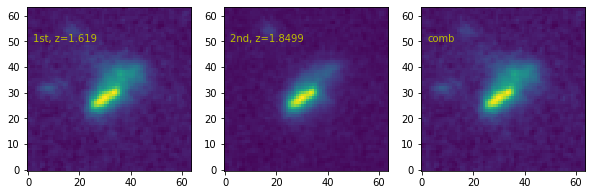

In [437]:
he = make_2blend(gals=1)